In [12]:
import dask.dataframe as dd
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import plotly 
import seaborn as sns
import gc

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import PolynomialFeatures
#from imblearn.under_sampling import RandomUnderSampler

In [13]:
ddf = dd.read_csv('../transactions_dataset.csv', sep=';')
ddf = ddf[ddf['sales_net'] > 0]  # Exclude the often duplicate 0 sales transactions 
                                # And exclude refunds 

# Compute the result to get a pandas DataFrame
df = ddf.compute()

In [14]:
df.columns

Index(['date_order', 'date_invoice', 'product_id', 'client_id', 'sales_net',
       'quantity', 'order_channel', 'branch_id'],
      dtype='object')

In [15]:
df.shape

(58514567, 8)

In [16]:
# Group by client and check the last date_order, then calculate the recency
df['date_order'] = pd.to_datetime(df['date_order'])
recency = df.groupby('client_id')['date_order'].max().reset_index()
recency['recency'] = recency['date_order'].max() - recency['date_order']
recency['recency'] = recency['recency'].apply(lambda x: x.days)

# Remove the date_order column
recency.drop('date_order', axis=1, inplace=True)

# Identify with a dummy those who have not bought in the last 30 days
recency['inactive'] = recency['recency'] > 30

In [17]:
# Restrict the data to people who bought something in the last 60 days 
recency = recency[recency['recency'] < 60]

# Calculate the proportion of churners
recency['inactive'].mean()

0.23134523007368443

In [18]:
# Add features such as number of different date_order, number of different products bought, nb of days since first order,
# average basket, frequency of orders

mask = df['date_order'] <= df['date_order'].max() - pd.Timedelta(days=30) # Remove the last month of data
features = df[mask].groupby(['client_id']).agg({'date_order': ['nunique', 'min'], 'product_id': 'nunique', 'sales_net': 'mean'})
features.columns = ['nb_orders', 'first_order', 'nb_products', 'average_basket']

# Create new features
features['days_since_first_order'] = (df['date_order'].max() - features['first_order']).dt.days
features['frequency'] = features['nb_orders'] / features['days_since_first_order']
features = features.drop('first_order', axis=1)

In [19]:
# Compute % of sales per channel for each client
mask = df['date_order'] <= df['date_order'].max() - pd.Timedelta(days=30) # Remove the last month of data
channel_sales = df[mask].groupby(['client_id', 'order_channel'])['sales_net'].sum().unstack(fill_value=0)
channel_sales = channel_sales.div(channel_sales.sum(axis=1), axis=0) * 100

In [20]:
# Merge features and channel_sales
features = features.merge(channel_sales, on='client_id', how='left')
features.head()

,nb_orders,nb_products,average_basket,days_since_first_order,frequency,at the store,by phone,during the visit of a sales rep,online,other
client_id,,,,,,,,,,
6,13,35,163.395361,695,0.018705,22.416561,77.583439,0.0,0.000000,0.0
7,2,10,79.385139,433,0.004619,100.000000,0.000000,0.0,0.000000,0.0
14,487,4757,260.104439,727,0.669876,1.949063,83.340556,0.0,14.710381,0.0
18,281,759,117.717070,726,0.387052,38.236234,56.830327,0.0,4.933439,0.0
25,1,4,93.646524,347,0.002882,100.000000,0.000000,0.0,0.000000,0.0


In [21]:
# Create a DF with monthly features
monthly_stats = df.loc[mask].groupby(['client_id', pd.Grouper(key='date_order', freq='M')]).agg({
    'date_order': 'nunique', 
    'sales_net': 'sum'
}).unstack(fill_value=0)

# Rename columns
monthly_stats.columns = [f"{col[0]}_{col[1].strftime('%Y-%m')}" for col in monthly_stats.columns]


# Fusionner avec le DataFrame features
#features = features.join(monthly_stats, on='client_id')


C:\Users\35387\AppData\Local\Temp\ipykernel_28968\3014166406.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stats = df.loc[mask].groupby(['client_id', pd.Grouper(key='date_order', freq='M')]).agg({


In [22]:
gc.collect()

7

In [23]:
# Compute the monthly evolutions in %
monthly_pct_change = monthly_stats.pct_change(axis=1).multiply(100).add_suffix('_pct_change')

# Replace inf with NaN
monthly_pct_change.replace([np.inf, -np.inf], np.nan, inplace=True)

In [24]:
# Calculer la variance de 'date_order' et 'sales_net' sur toute la période
# Calculer la variance pour chaque type de colonne
date_order_variance = monthly_stats.filter(like='date_order').var(axis=1).rename('date_order_variance')
sales_net_variance = monthly_stats.filter(like='sales_net').var(axis=1).rename('sales_net_variance')

# Moyennes sur les 6 et 3 derniers mois
rolling_6m = monthly_stats.rolling(window=6, axis=1).mean().add_suffix('_avg_6m')
rolling_3m = monthly_stats.rolling(window=3, axis=1).mean().add_suffix('_avg_3m')
rolling_6m = rolling_6m[['date_order_2019-08_avg_6m', 'sales_net_2019-08_avg_6m']]
rolling_3m = rolling_3m[['date_order_2019-08_avg_3m', 'sales_net_2019-08_avg_3m']]

C:\Users\35387\AppData\Local\Temp\ipykernel_28968\3604132426.py:7: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  rolling_6m = monthly_stats.rolling(window=6, axis=1).mean().add_suffix('_avg_6m')
C:\Users\35387\AppData\Local\Temp\ipykernel_28968\3604132426.py:8: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  rolling_3m = monthly_stats.rolling(window=3, axis=1).mean().add_suffix('_avg_3m')


In [25]:
# Merge with features
features_v2 = features.join(monthly_stats, on='client_id')
features_v2 = features_v2.join(monthly_pct_change, on='client_id')
features_v2 = features_v2.join(date_order_variance, on='client_id')
features_v2 = features_v2.join(sales_net_variance, on='client_id')
features_v2 = features_v2.join(rolling_6m, on='client_id')
features_v2 = features_v2.join(rolling_3m, on='client_id')

In [61]:
# Merge the two dataframes
data = recency.merge(features_v2, on='client_id', how='left')

In [62]:
data.shape

(92014, 115)

In [63]:
data.head()

,client_id,recency,inactive,nb_orders,nb_products,average_basket,days_since_first_order,frequency,at the store,by phone,...,sales_net_2019-05_pct_change,sales_net_2019-06_pct_change,sales_net_2019-07_pct_change,sales_net_2019-08_pct_change,date_order_variance,sales_net_variance,date_order_2019-08_avg_6m,sales_net_2019-08_avg_6m,date_order_2019-08_avg_3m,sales_net_2019-08_avg_3m
0,6,40,True,13.0,35.0,163.395361,695.0,0.018705,22.416561,77.583439,...,NaN,NaN,NaN,-97.386934,0.693841,2.950564e+05,0.500000,398.307645,1.000000,796.615290
1,14,2,False,487.0,4757.0,260.104439,727.0,0.669876,1.949063,83.340556,...,6.284473,97.052861,-23.775473,-33.318698,14.215580,3.242250e+09,20.666667,136164.647550,20.000000,146696.968445
2,18,10,False,281.0,759.0,117.717070,726.0,0.387052,38.236234,56.830327,...,-66.631033,103.905871,88.616446,-37.877837,11.606884,3.396692e+07,12.500000,10724.690309,13.333333,12845.564697
3,40,20,False,57.0,138.0,204.666585,727.0,0.078404,40.242711,59.757289,...,301.745584,-15.498107,-26.435417,49.690669,2.418478,1.430422e+06,2.500000,1478.598051,3.000000,1854.646584
4,56,20,False,29.0,114.0,83.126516,696.0,0.041667,80.081339,19.918661,...,445.847492,-51.765622,-100.000000,NaN,1.563406,3.340104e+05,0.666667,227.356005,0.666667,131.685120


In [ ]:
# Remove the clients with nb_orders = NaN (those who had their first order in the last month)
#data = data.dropna()

In [64]:
# Merge with the client relationship dataset
client_relationship = pd.read_csv('../sales_client_relationship_dataset.csv')

data = data.merge(client_relationship, on='client_id', how='left')

data.head()

,client_id,recency,inactive,nb_orders,nb_products,average_basket,days_since_first_order,frequency,at the store,by phone,...,sales_net_2019-06_pct_change,sales_net_2019-07_pct_change,sales_net_2019-08_pct_change,date_order_variance,sales_net_variance,date_order_2019-08_avg_6m,sales_net_2019-08_avg_6m,date_order_2019-08_avg_3m,sales_net_2019-08_avg_3m,quali_relation
0,6,40,True,13.0,35.0,163.395361,695.0,0.018705,22.416561,77.583439,...,NaN,NaN,-97.386934,0.693841,2.950564e+05,0.500000,398.307645,1.000000,796.615290,Agreeable client
1,14,2,False,487.0,4757.0,260.104439,727.0,0.669876,1.949063,83.340556,...,97.052861,-23.775473,-33.318698,14.215580,3.242250e+09,20.666667,136164.647550,20.000000,146696.968445,Agreeable client
2,18,10,False,281.0,759.0,117.717070,726.0,0.387052,38.236234,56.830327,...,103.905871,88.616446,-37.877837,11.606884,3.396692e+07,12.500000,10724.690309,13.333333,12845.564697,Agreeable client
3,40,20,False,57.0,138.0,204.666585,727.0,0.078404,40.242711,59.757289,...,-15.498107,-26.435417,49.690669,2.418478,1.430422e+06,2.500000,1478.598051,3.000000,1854.646584,Difficult client
4,56,20,False,29.0,114.0,83.126516,696.0,0.041667,80.081339,19.918661,...,-51.765622,-100.000000,NaN,1.563406,3.340104e+05,0.666667,227.356005,0.666667,131.685120,Agreeable client


c:\Users\35387\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


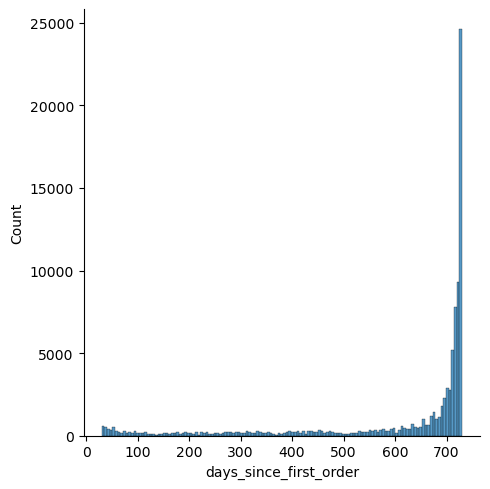

In [65]:
# Check the distribution of days_since_first_order
sns.displot(data['days_since_first_order'])

In [66]:
data['days_since_first_order'].max()

730.0

In [67]:
# Replace the days_since_first_order by a categorical variable
# If days_since_first_order > 650, then old_client = 1
data['old_client'] = data['days_since_first_order'] > 650

# Remove the days_since_first_order column
data = data.drop('days_since_first_order', axis=1)

In [68]:
# Change the names of some columns
data = data.rename(columns={'at the store': 'at_store', 'by phone': 'phone',
                            'during the visit of a sales rep': 'sales_rep'})

In [69]:
# Transform quali_relation into dummies
data = pd.get_dummies(data, columns=['quali_relation'])

In [79]:
data.drop(columns=['date_order_2017-09_pct_change'], inplace=True)

### Train a model

#### v1 : rf

In [76]:
data

,client_id,recency,inactive,nb_orders,nb_products,average_basket,frequency,at_store,phone,sales_rep,...,date_order_variance,sales_net_variance,date_order_2019-08_avg_6m,sales_net_2019-08_avg_6m,date_order_2019-08_avg_3m,sales_net_2019-08_avg_3m,old_client,quali_relation_Agreeable client,quali_relation_Demanding client,quali_relation_Difficult client
0,6,40,True,13.0,35.0,163.395361,0.018705,22.416561,77.583439,0.0,...,0.693841,2.950564e+05,0.500000,398.307645,1.000000,796.615290,True,True,False,False
1,14,2,False,487.0,4757.0,260.104439,0.669876,1.949063,83.340556,0.0,...,14.215580,3.242250e+09,20.666667,136164.647550,20.000000,146696.968445,True,True,False,False
2,18,10,False,281.0,759.0,117.717070,0.387052,38.236234,56.830327,0.0,...,11.606884,3.396692e+07,12.500000,10724.690309,13.333333,12845.564697,True,True,False,False
3,40,20,False,57.0,138.0,204.666585,0.078404,40.242711,59.757289,0.0,...,2.418478,1.430422e+06,2.500000,1478.598051,3.000000,1854.646584,True,False,False,True
4,56,20,False,29.0,114.0,83.126516,0.041667,80.081339,19.918661,0.0,...,1.563406,3.340104e+05,0.666667,227.356005,0.666667,131.685120,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92009,2274398,20,False,10.0,37.0,306.110773,0.014025,0.000000,100.000000,0.0,...,0.514493,2.818196e+06,0.166667,1282.352427,0.333333,2564.704853,True,True,False,False
92010,2274410,10,False,92.0,224.0,68.305927,0.128134,52.266890,47.733110,0.0,...,6.927536,1.171794e+06,5.333333,1647.072700,4.333333,1421.070536,True,False,True,False
92011,2274440,10,False,24.0,87.0,198.413397,0.033149,29.477999,70.522001,0.0,...,0.956522,5.014314e+06,1.166667,283.109208,1.000000,372.475432,True,False,False,True
92012,2274456,20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True


In [80]:
data.dropna(inplace=True)

In [81]:
y =  data['inactive']
X = data.drop(['client_id', 'inactive', 'recency'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

[[4967    0]
 [  64    0]]
              precision    recall  f1-score   support

       False       0.99      1.00      0.99      4967
        True       0.00      0.00      0.00        64

    accuracy                           0.99      5031
   macro avg       0.49      0.50      0.50      5031
weighted avg       0.97      0.99      0.98      5031

AUC-ROC: 0.8390926993154821


c:\Users\35387\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  
c:\Users\35387\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  
c:\Users\35387\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  


#### rf with balanced dataset: undersampling

In [39]:
def manual_undersample(X, y):
    # Combine features and target into a single DataFrame
    data = pd.concat([X, y], axis=1)

    # Identify the minority and majority classes
    class_counts = y.value_counts()
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()

    # Separate the minority and majority classes
    minority_class_data = data[data[y.name] == minority_class]
    majority_class_data = data[data[y.name] == majority_class]

    # Undersample the majority class
    majority_class_undersampled = majority_class_data.sample(n=len(minority_class_data), random_state=42)

    # Combine the minority class with the undersampled majority class
    undersampled_data = pd.concat([minority_class_data, majority_class_undersampled])

    # Shuffle the data
    undersampled_data = undersampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Separate features and target
    X_undersampled = undersampled_data.drop(y.name, axis=1)
    y_undersampled = undersampled_data[y.name]

    return X_undersampled, y_undersampled

In [41]:
# Balance the training set (undersample the majority class)
#rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = manual_undersample(X_train, y_train)
#X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [42]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

[[14650  6511]
 [  788  5656]]
              precision    recall  f1-score   support

       False       0.95      0.69      0.80     21161
        True       0.46      0.88      0.61      6444

    accuracy                           0.74     27605
   macro avg       0.71      0.79      0.70     27605
weighted avg       0.84      0.74      0.76     27605

AUC-ROC: 0.8608268372907999


#### v2 : rf with polynomial features and resampling

In [43]:
# Add polynomial features
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train_resampled)
X_test_poly = poly.transform(X_test)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\35387\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\35387\AppData\Local\Temp\ipykernel_28968\626176542.py", line 3, in <module>
    X_train_poly = poly.fit_transform(X_train_resampled)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\35387\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 273, in wrapped
    raise ValueError(
                   ^^^
  File "c:\Users\35387\anaconda3\Lib\site-packages\sklearn\base.py", line 1061, in fit_transform
    Estimator object to test.
               ^^^^^^^^^^^^^^^
  File "c:\Users\35387\anaconda3\Lib\site-packages\sklearn\base.py", line 1351, in wrapper
  File "c:\Users\35387\anaconda3\Lib\site-packages\sklearn\preprocessing\_polynomial.py", line 322, in fit
  File "c:\Users\35387\anaconda3\Lib\site-packages\sklearn\base.py", line 633, in _validate

In [115]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_poly, y_train_resampled)

y_pred = model.predict(X_test_poly)
y_pred_proba = model.predict_proba(X_test_poly)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))


[[13090  7548]
 [ 1517  4945]]
              precision    recall  f1-score   support

       False       0.90      0.63      0.74     20638
        True       0.40      0.77      0.52      6462

    accuracy                           0.67     27100
   macro avg       0.65      0.70      0.63     27100
weighted avg       0.78      0.67      0.69     27100

AUC-ROC: 0.7659306095923811


#### v3 : XGBoost with polynomial features and resampling

In [101]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train_resampled)
X_test_poly = poly.transform(X_test)

In [100]:
# XGboost model
model = XGBClassifier(n_estimators=20, random_state=42)
model.fit(X_train_poly, y_train_resampled)

y_pred = model.predict(X_test_poly)
y_pred_proba = model.predict_proba(X_test_poly)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

[[12419  8219]
 [ 1025  5437]]
              precision    recall  f1-score   support

       False       0.92      0.60      0.73     20638
        True       0.40      0.84      0.54      6462

    accuracy                           0.66     27100
   macro avg       0.66      0.72      0.63     27100
weighted avg       0.80      0.66      0.68     27100

AUC-ROC: 0.7856768046995068


#### v4 : XGBoost without polynomial features and resampling

In [1]:
y =  data['inactive']
X = data.drop(['client_id', 'inactive', 'recency'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

NameError: name 'data' is not defined

In [105]:
# Balance the training set (undersample the majority class)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [112]:
# XGboost model
model = XGBClassifier(n_estimators=20, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

[[12388  8250]
 [ 1015  5447]]
              precision    recall  f1-score   support

       False       0.92      0.60      0.73     20638
        True       0.40      0.84      0.54      6462

    accuracy                           0.66     27100
   macro avg       0.66      0.72      0.63     27100
weighted avg       0.80      0.66      0.68     27100

AUC-ROC: 0.786822728078595


Approximately the same

### Train a model (v2 with added monthly features)

In [76]:
data.dropna(subset=['nb_orders'], inplace=True)

In [80]:
# Replace all NaN values by 0
data.fillna(0, inplace=True)

#### v1 : rf

In [81]:
y =  data['inactive']
X = data.drop(['client_id', 'inactive', 'recency'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [83]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

[[19030  1608]
 [ 3543  2919]]
              precision    recall  f1-score   support

       False       0.84      0.92      0.88     20638
        True       0.64      0.45      0.53      6462

    accuracy                           0.81     27100
   macro avg       0.74      0.69      0.71     27100
weighted avg       0.80      0.81      0.80     27100

AUC-ROC: 0.8576003933212057


#### rf with balanced dataset: undersampling

In [84]:
# Balance the training set (undersample the majority class)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [85]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

[[14832  5806]
 [ 1031  5431]]
              precision    recall  f1-score   support

       False       0.94      0.72      0.81     20638
        True       0.48      0.84      0.61      6462

    accuracy                           0.75     27100
   macro avg       0.71      0.78      0.71     27100
weighted avg       0.83      0.75      0.77     27100

AUC-ROC: 0.8574085781490597


#### v2 : rf with polynomial features and resampling

In [86]:
# Add polynomial features
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train_resampled)
X_test_poly = poly.transform(X_test)

In [87]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_poly, y_train_resampled)

y_pred = model.predict(X_test_poly)
y_pred_proba = model.predict_proba(X_test_poly)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))


[[15118  5520]
 [ 1156  5306]]
              precision    recall  f1-score   support

       False       0.93      0.73      0.82     20638
        True       0.49      0.82      0.61      6462

    accuracy                           0.75     27100
   macro avg       0.71      0.78      0.72     27100
weighted avg       0.82      0.75      0.77     27100

AUC-ROC: 0.8572846867381776


#### v3 : XGBoost with polynomial features and resampling

In [88]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train_resampled)
X_test_poly = poly.transform(X_test)

In [89]:
# XGboost model
model = XGBClassifier(n_estimators=20, random_state=42)
model.fit(X_train_poly, y_train_resampled)

y_pred = model.predict(X_test_poly)
y_pred_proba = model.predict_proba(X_test_poly)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

[[14421  6217]
 [  914  5548]]
              precision    recall  f1-score   support

       False       0.94      0.70      0.80     20638
        True       0.47      0.86      0.61      6462

    accuracy                           0.74     27100
   macro avg       0.71      0.78      0.71     27100
weighted avg       0.83      0.74      0.76     27100

AUC-ROC: 0.8600179798323903


#### v4 : XGBoost without polynomial features and resampling

In [90]:
y =  data['inactive']
X = data.drop(['client_id', 'inactive', 'recency'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [91]:
# Balance the training set (undersample the majority class)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [92]:
# XGboost model
model = XGBClassifier(n_estimators=20, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

[[14530  6108]
 [  919  5543]]
              precision    recall  f1-score   support

       False       0.94      0.70      0.81     20638
        True       0.48      0.86      0.61      6462

    accuracy                           0.74     27100
   macro avg       0.71      0.78      0.71     27100
weighted avg       0.83      0.74      0.76     27100

AUC-ROC: 0.860677133127033


#### v5 : XGBoost without polynomial features and without resampling

In [93]:
y =  data['inactive']
X = data.drop(['client_id', 'inactive', 'recency'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [94]:
# XGboost model
model = XGBClassifier(n_estimators=20, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

[[18879  1759]
 [ 3287  3175]]
              precision    recall  f1-score   support

       False       0.85      0.91      0.88     20638
        True       0.64      0.49      0.56      6462

    accuracy                           0.81     27100
   macro avg       0.75      0.70      0.72     27100
weighted avg       0.80      0.81      0.80     27100

AUC-ROC: 0.8627802052920982
